### Working with GPUs



    Work in CPU mode while developing your models and such.
    Make sure the network is learning (the training loss is dropping) using just the CPU.
    When you're ready to train for real and optimize the hyperparameters, enable the GPU

All models and data they see as input will have to be moved to the GPU device, so take note of the relevant movement code in the model creation and training process.

More READING

CUDA semantics: https://pytorch.org/docs/stable/notes/cuda.html#cuda-semantics

Torch.cuda : https://pytorch.org/docs/stable/cuda.html

In [4]:
import torch

# to check if a GPU is available in your system and supports CUDA
cuda = torch.cuda.is_available()
cuda

True

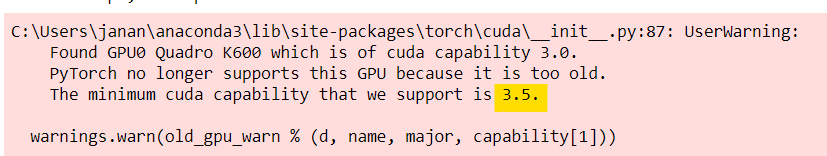

* model.to('cpu')   -> move model to cpu
* model.to('cuda')  -> move model to gpu

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

data_dir = '~/.pytorch/Cat_Dog_data/Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

# import pretrained model - desnet
model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [6]:
import time

for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 3.367 seconds


C:\Users\janan\anaconda3\lib\site-packages\torch\cuda\__init__.py:87: UserWarning: 
    Found GPU0 Quadro K600 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

### device agnostic code 

TIP: Use this line in the beginning to pick up cuda if it is available

In [7]:
device = torch.device( "cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)